# Stats of Extreme Events

https://scia.isprambiente.it/

Regione Selezionata: Sicilia



In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [101]:

series = pd.read_csv("Sicilia.csv")

# parsing coerente col tuo formato (JAN-01-1952)
series["data"] = pd.to_datetime(series["data"], format="%b-%d-%Y", errors="coerce")

# numerico
series["Precipitazioni cumulate"] = pd.to_numeric(series["Precipitazioni cumulate"], errors="coerce")

# filtro periodo (per essere sicuro)
series = series[(series["data"] >= "1951-01-01") & (series["data"] <= "2022-12-31")]


In [102]:
print(type(series))
series

<class 'pandas.core.frame.DataFrame'>


,rete,anagrafica,data,Precipitazioni cumulate
0,REGIONI - ex SIMN,Milazzo,1958-02-01,0.0
1,REGIONI - ex SIMN,Milazzo,1958-02-02,0.0
2,REGIONI - ex SIMN,Milazzo,1958-02-03,0.0
3,REGIONI - ex SIMN,Milazzo,1958-02-04,0.0
4,REGIONI - ex SIMN,Milazzo,1958-02-05,0.0
...,...,...,...,...
305760,RETE SICILIA OSS. ACQUE TEMP,S.STEFANO DI BRIGA,2022-12-27,0.0
305761,RETE SICILIA OSS. ACQUE TEMP,S.STEFANO DI BRIGA,2022-12-28,0.0
305762,RETE SICILIA OSS. ACQUE TEMP,S.STEFANO DI BRIGA,2022-12-29,0.0
305763,RETE SICILIA OSS. ACQUE TEMP,S.STEFANO DI BRIGA,2022-12-30,0.0


In [103]:
# stampo il primo valore della riga ("data")
series.index[0]

np.int64(0)

In [104]:
print(len(series))

255079


In [105]:
# raggruppo i dati su ogni giorno e considero il massimo
# rimuovo le colonne rete e anagrafica
data = series.groupby(["data"]).max().drop(["rete","anagrafica"], axis=1).squeeze()
data

data
1951-01-01     2.080
1951-01-02     0.938
1951-01-03     4.632
1951-01-04    20.000
1951-01-05    10.000
               ...  
2022-12-27     0.300
2022-12-28     0.400
2022-12-29     0.300
2022-12-30     0.200
2022-12-31     0.400
Name: Precipitazioni cumulate, Length: 26298, dtype: float64

In [106]:
print(len(data))

26298


In [107]:
from pyextremes import EVA

model = EVA(data)

In [108]:
model.get_extremes(method="BM", block_size="365.2425D",errors="coerce")

In [109]:
# Restituisce i valori estremi
print(len(model.extremes))
model.extremes

72


data
1951-10-17    225.0
1952-02-06     85.0
1953-10-27    124.0
1954-12-13     95.0
1955-01-24     87.2
              ...  
2018-10-04    121.8
2019-11-12     92.2
2020-07-04     94.2
2021-10-25    153.9
2022-11-26     75.9
Name: Precipitazioni cumulate, Length: 72, dtype: float64

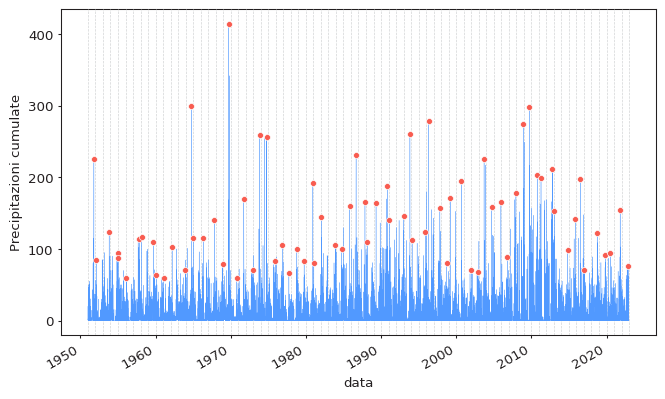

In [110]:
model.plot_extremes()
plt.show()

In [111]:
# Ordino i massimi dal più grande al più piccolo
model.extremes.sort_values(ascending=False)

data
1969-09-30    414.6
1964-09-30    300.0
2009-09-25    299.0
1996-05-10    278.9
2008-12-11    275.1
              ...  
1977-09-27     65.8
1960-02-01     63.5
1961-01-24     60.0
1970-10-17     60.0
1956-02-05     59.2
Name: Precipitazioni cumulate, Length: 72, dtype: float64

In [112]:
# Ottimizzazione della likelihood con il metodo Akaike Information Criterion (AIC)
model.fit_model()


In [113]:
# Stima dei valori attesi tra 1, 2, 5 e 10 anni
summary = model.get_summary(
    return_period=[1, 2, 5, 10],
    alpha=0.95, # intervallo di confidenza
    n_samples=1000, # campioni utilizzati per la stima
)

In [114]:
summary

,return value,lower ci,upper ci
return period,,,
1.0,-61.519713,NaN,59.999977
2.0,123.062193,64.313506,144.754343
5.0,186.978971,160.605674,2417.936875
10.0,241.048066,205.093614,137725.076954


## Empirical Return Periods

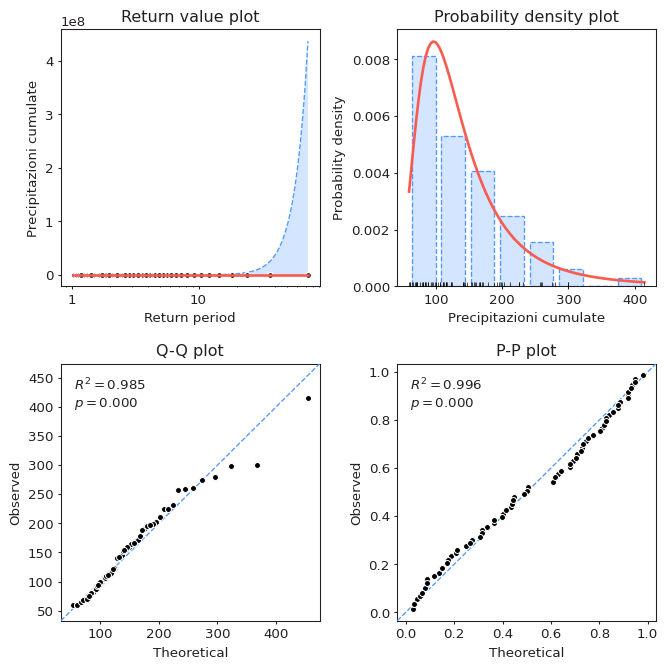

In [115]:
# Genera dei grafici sul periodo di ritorno, sulla densità di probabilità

model.plot_diagnostic(alpha=0.95)
plt.show()

In [116]:
# Distribuzione genextreme (GEV)
# parametri: c è ξ (forma, < 0 è Weibull) loc è μ (posizione), scale è σ (dispersione)
print(model.distribution)

               pyextremes distribution                
------------------------------------------------------
name: genextreme                                      
free parameters: c, loc, scale                        
fixed parameters: all parameters are free             
fitted parameters: c=-0.262, loc=106.141, scale=43.984
------------------------------------------------------


## Estimating Return Periods

In [117]:
from pyextremes import get_return_periods

return_periods = get_return_periods(
    ts=data,
    extremes=model.extremes,
    extremes_method="BM",
    extremes_type="high",
    block_size="365.2425D",
    return_period_size="365.2425D"
)
return_periods.sort_values("return period", ascending=False).head(10)

,Precipitazioni cumulate,exceedance probability,return period
data,,,
1969-09-30,414.6,0.013699,73.000000
1964-09-30,300.0,0.027397,36.500000
2009-09-25,299.0,0.041096,24.333333
1996-05-10,278.9,0.054795,18.250000
2008-12-11,275.1,0.068493,14.600000
1993-11-04,260.1,0.082192,12.166667
1973-11-08,259.1,0.095890,10.428571
1974-10-13,257.0,0.109589,9.125000
1986-09-06,230.9,0.123288,8.111111


## Peaks Over Threshold

In [118]:
model2 = EVA(data)

model2.get_extremes("POT", threshold=91, r="30D")

#la soglia di 91 è stata decisa facendo dei test ed osservando
# Threshold Selection e facendo delle valutazioni sul diagnosticplot e valutando gli R^2 ed il summary in basso



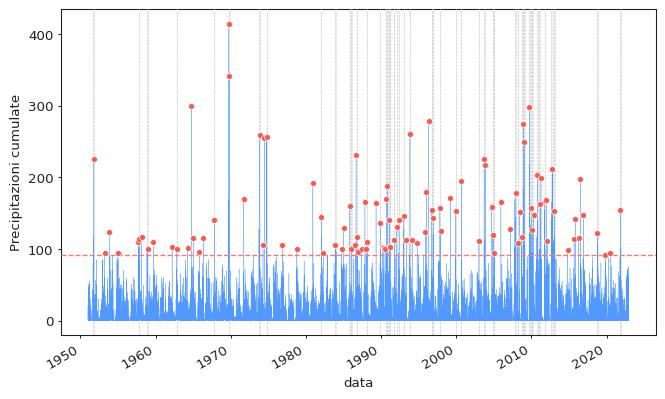

In [119]:
model2.plot_extremes(show_clusters=True)
plt.show()

In [120]:

print(len(model2.extremes))
model2.extremes

105


data
1951-10-17    225.0
1953-03-16     95.0
1953-10-27    124.0
1954-12-13     95.0
1957-09-05    110.0
              ...  
2016-11-25    147.8
2018-10-04    121.8
2019-11-12     92.2
2020-07-04     94.2
2021-10-25    153.9
Name: Precipitazioni cumulate, Length: 105, dtype: float64

In [121]:
# Ordino i massimi dal più grande al più piccolo
model2.extremes.sort_values(ascending=False)

data
1969-09-30    414.6
1969-10-31    342.0
1964-09-30    300.0
2009-09-25    299.0
1996-05-10    278.9
              ...  
1953-03-16     95.0
2005-01-23     95.0
2020-07-04     94.2
1982-04-24     94.0
2019-11-12     92.2
Name: Precipitazioni cumulate, Length: 105, dtype: float64

In [122]:
# Ottimizzazione della likelihood specificando di utilizzare la distribuzione GPD

model2.fit_model(distribution="genpareto", distribution_kwargs={})

In [123]:
# Stima dei valori attesi tra 1, 2, 5 e 10 anni
# Nota: tempo di esecuzione di circa 2 minuti
summary2 = model2.get_summary(
    return_period=[1, 2, 5, 10],
    alpha=0.95, # intervallo di confidenza
    n_samples=1000, # campioni utilizzati per la stima
)

In [124]:
summary2

,return value,lower ci,upper ci
return period,,,
1.0,114.151216,107.717316,138.102969
2.0,154.967032,141.968137,203.599562
5.0,209.911037,187.390837,268.162917
10.0,252.235347,221.131516,380.889131


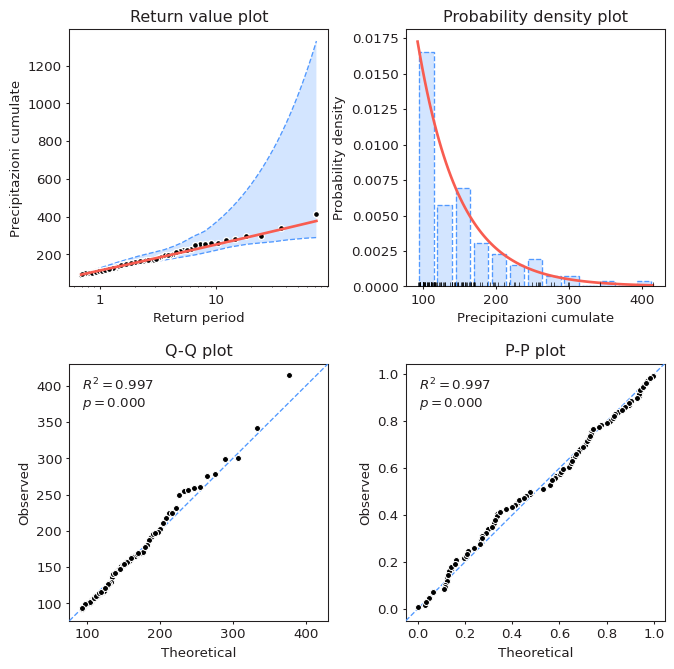

In [125]:
model2.plot_diagnostic(alpha=0.95)
plt.show()

##Questi R^2 sono stati ottenuti eseguendo una selezione della soglia, tramite algoritmi, e testando quale di questi forniva una miglior rappresentazione Q-Q e P-P plot. Soglia selezionata 91

In [126]:
# Distribuzione genpareto (GPD)
# parametri: c è ξ (forma) loc è μ (posizione), scale è σ (scala)
model2.distribution

              pyextremes distribution               
----------------------------------------------------
name: genpareto                                     
free parameters: c, loc, scale                      
fixed parameters: all parameters are free           
fitted parameters: c=0.023, loc=92.200, scale=57.931
----------------------------------------------------

## Threshold Selection

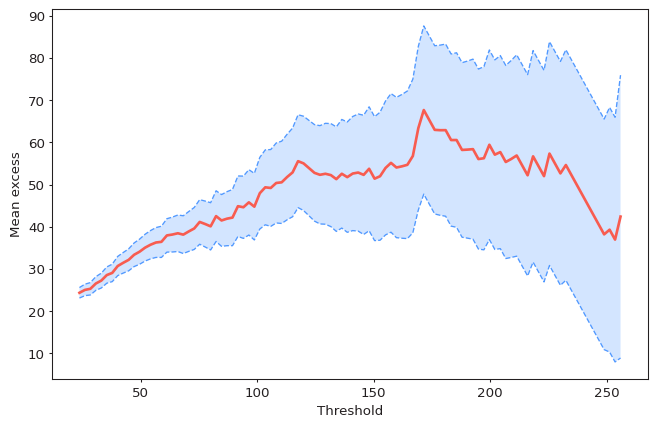

In [127]:
# Mean Residual Life
# informazioni: https://georgebv.github.io/pyextremes/user-guide/5-threshold-selection/#mean-residual-life
from pyextremes import plot_mean_residual_life

plot_mean_residual_life(data)
plt.show()

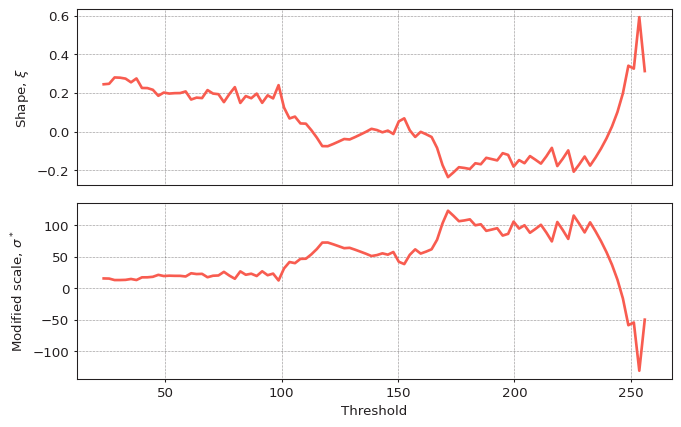

In [128]:
# Parameter Stability
# informazioni: https://georgebv.github.io/pyextremes/user-guide/5-threshold-selection/#parameter-stability
from pyextremes import plot_parameter_stability

plot_parameter_stability(data)
plt.show()

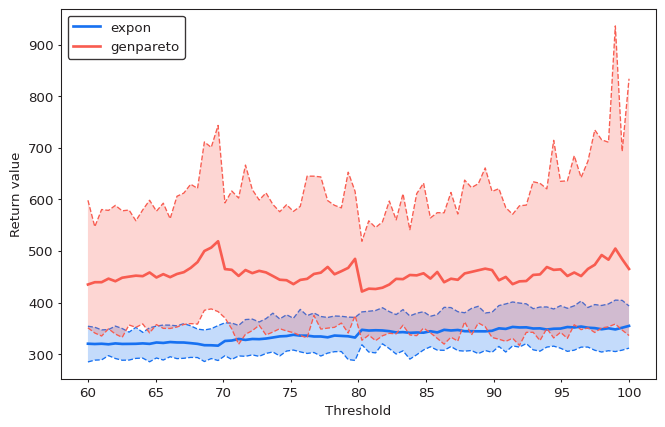

In [129]:
#Return Value Stability
# informazioni: https://georgebv.github.io/pyextremes/user-guide/5-threshold-selection/#return-value-stability
from pyextremes import plot_return_value_stability
import numpy as np

plot_return_value_stability(
    data,
    return_period=100,
    thresholds=np.linspace(60, 100, 80),
    alpha=0.95,
)
plt.show()

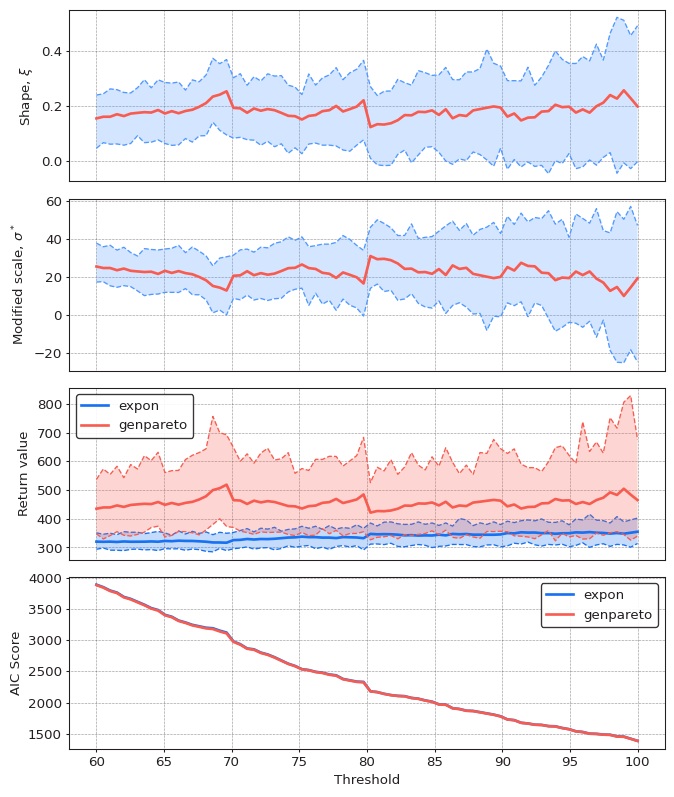

In [130]:
# Tutti i metodi insieme
from pyextremes import plot_threshold_stability

plot_threshold_stability(
    data,
    return_period=100,
    thresholds=np.linspace(60, 100, 80),
    alpha=0.95
)
plt.show()

## Metodo di selezione Basato su R^2 PP QQ

In [131]:
##Funzione per estrazione R^2

import re

def extract_r2_from_diagnostic(model):
    """
    Estrae i valori numerici di R² (QQ e PP) dai plot generati da pyextremes.plot_diagnostic,
    SENZA visualizzare nulla.

    Parametri:
        model: oggetto ThresholdModel già fittato (pyextremes)

    Ritorna:
        r2_qq (float): valore R² del QQ plot
        r2_pp (float): valore R² del PP plot
    """
    # Genera i plot (senza mostrarli)
    fig, (ax_rv, ax_pdf, ax_qq, ax_pp) = model.plot_diagnostic(alpha=0.95)
    fig.canvas.draw()  # forza il rendering per popolare ax.texts

    def get_r2_from_ax(ax):
        for txt in ax.texts:
            content = txt.get_text()
            match = re.search(r"R\^?2\s*=\s*([0-9.]+)", content)
            if match:
                return float(match.group(1))
        return float("nan")

    r2_qq = get_r2_from_ax(ax_qq)
    r2_pp = get_r2_from_ax(ax_pp)

    plt.close(fig)  # evita visualizzazione
    return r2_qq, r2_pp


## Procediamo all'identificazione della migliore soglia

In [132]:

import pandas as pd


best_qq = {"threshold": None, "r2": -1}
best_pp = {"threshold": None, "r2": -1}
results = []  # lista per salvare ogni soglia e R² associati

for n in range(80, 120):
    try:
        model2.get_extremes("POT", threshold=n, r="30D")
        model2.fit_model(distribution="genpareto", distribution_kwargs={})

        r2_qq, r2_pp = extract_r2_from_diagnostic(model2)
        print(f"Soglia {n} → R² QQ: {r2_qq:.4f}, R² PP: {r2_pp:.4f}")

        results.append({
            "threshold": n,
            "r2_qq": r2_qq,
            "r2_pp": r2_pp
        })

        if r2_qq > best_qq["r2"]:
            best_qq = {"threshold": n, "r2": r2_qq}
        if r2_pp > best_pp["r2"]:
            best_pp = {"threshold": n, "r2": r2_pp}

    except Exception as e:
        print(f" Errore alla soglia {n}: {e}")

# Risultati finali
print("\n Miglior R² QQ:")
print(f"Soglia: {best_qq['threshold']}, R² QQ: {best_qq['r2']:.4f}")

print("\n Miglior R² PP:")
print(f"Soglia: {best_pp['threshold']}, R² PP: {best_pp['r2']:.4f}")

# DataFrame con tutti i risultati
df_results = pd.DataFrame(results)
df_sorted = df_results.sort_values(by="r2_pp", ascending=False)

print("\n Top soglie ordinate per R² PP:")
print(df_sorted.head(5).to_string(index=False))


Soglia 80 → R² QQ: 0.9920, R² PP: 0.9960
Soglia 81 → R² QQ: 0.9250, R² PP: 0.9970
Soglia 82 → R² QQ: 0.9970, R² PP: 0.9980
Soglia 83 → R² QQ: 0.7870, R² PP: 0.9940
Soglia 84 → R² QQ: 0.9900, R² PP: 0.9950
Soglia 85 → R² QQ: 0.9970, R² PP: 0.9980
Soglia 86 → R² QQ: 0.9970, R² PP: 0.9980
Soglia 87 → R² QQ: 0.9970, R² PP: 0.9970
Soglia 88 → R² QQ: 0.9970, R² PP: 0.9970
Soglia 89 → R² QQ: 0.9950, R² PP: 0.9970
Soglia 90 → R² QQ: 0.9970, R² PP: 0.9970
Soglia 91 → R² QQ: 0.9970, R² PP: 0.9970
Soglia 92 → R² QQ: 0.9970, R² PP: 0.9970
Soglia 93 → R² QQ: 0.9970, R² PP: 0.9970
Soglia 94 → R² QQ: 0.9970, R² PP: 0.9970
Soglia 95 → R² QQ: 0.9120, R² PP: 0.9960
Soglia 96 → R² QQ: 0.9930, R² PP: 0.9960
Soglia 97 → R² QQ: 0.9930, R² PP: 0.9960
Soglia 98 → R² QQ: 0.9930, R² PP: 0.9960
Soglia 99 → R² QQ: 0.9510, R² PP: 0.9930
Soglia 100 → R² QQ: 0.9970, R² PP: 0.9970
Soglia 101 → R² QQ: 0.9960, R² PP: 0.9970
Soglia 102 → R² QQ: 0.9960, R² PP: 0.9970
Soglia 103 → R² QQ: 0.9960, R² PP: 0.9970
Soglia 104 →

# Dopo aver identificato la soglia migliore plottiamo ed analizziamo il risultato

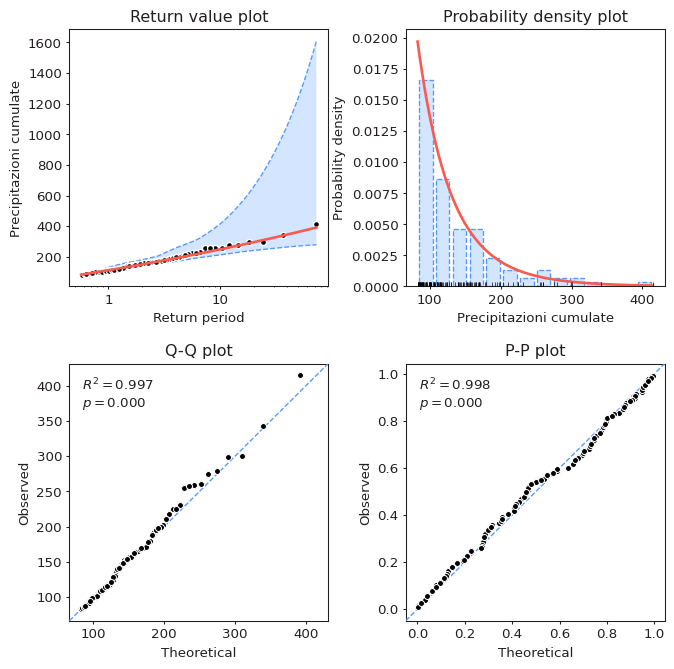

In [133]:
model2.get_extremes("POT", threshold=82, r="30D")
model2.fit_model(distribution="genpareto", distribution_kwargs={})
model2.plot_diagnostic(alpha=0.95)
plt.show()

In [134]:
model2.distribution

              pyextremes distribution               
----------------------------------------------------
name: genpareto                                     
free parameters: c, loc, scale                      
fixed parameters: all parameters are free           
fitted parameters: c=0.090, loc=82.984, scale=50.715
----------------------------------------------------

In [135]:
summary_82 = model2.get_summary(
    return_period=[1, 2, 5, 10],
    alpha=0.95, # intervallo di confidenza
    n_samples=1000, # campioni utilizzati per la stima
)

In [136]:
summary_82

,return value,lower ci,upper ci
return period,,,
1.0,112.516856,104.790096,136.002343
2.0,150.698764,137.190274,185.875396
5.0,204.980538,183.081695,276.587804
10.0,249.130358,214.483254,394.789518


# Analisi per stazione: return levels (BM)
In questa sezione ripetiamo la stessa logica EVA usata prima, ma applicata alle singole stazioni.
L’obiettivo è confrontare i return levels tra stazioni.

In [137]:
import numpy as np
import pandas as pd
from pyextremes import EVA

# Copia e pulizia minima coerente con il notebook
df_st = series.copy()

df_st = df_st.dropna(subset=["data", "Precipitazioni cumulate"])
df_st = df_st[df_st["Precipitazioni cumulate"] >= 0]

# Coverage minima: tieni solo stazioni con almeno N anni di dati
MIN_YEARS = 30

years_cov = df_st.groupby("anagrafica")["data"].agg(lambda x: x.dt.year.nunique())
st_ok = years_cov[years_cov >= MIN_YEARS].index
df_st = df_st[df_st["anagrafica"].isin(st_ok)]

print("Stazioni totali nel CSV:", series["anagrafica"].nunique())
print(f"Stazioni con coverage >= {MIN_YEARS} anni:", df_st["anagrafica"].nunique())


Stazioni totali nel CSV: 31
Stazioni con coverage >= 30 anni: 10


In [138]:
# ============================================================
# SCOPO (perché esiste questo blocco)
# ============================================================
# In pyextremes, a seconda della versione installata, il metodo che
# restituisce i "return values / return levels" può cambiare:
#
# - Versioni "nuove": EVA.get_return_values(...) restituisce direttamente
#   un DataFrame con return value e intervalli di confidenza.
#
# - Versioni "vecchie": EVA.get_return_value(...) restituisce un valore
#   singolo per un return period, ma il formato dell'output può variare
#   (float, dict, tuple con CI, Series, ecc).
#
# Questo blocco serve a rendere il notebook robusto e riusabile:
# indipendentemente dalla versione, alla fine otteniamo SEMPRE una tabella
# standard con le colonne:
#   - return value
#   - lower ci
#   - upper ci
#
# In pratica: evitare crash e output incoerenti quando l'ambiente cambia
# (PC diverso, venv diverso, pyextremes aggiornato o meno).
# ============================================================

import numpy as np
import pandas as pd

def _parse_return_value_object(rv):
    """
    SCOPO:
    Normalizzare l'output restituito da EVA.get_return_value(...) in un formato unico.

    PERCHÉ:
    In alcune versioni/setting, get_return_value può restituire:
    - un numero semplice (float)
    - una tupla (rv, lo, hi)
    - una tupla (rv, (lo, hi))
    - un dict con chiavi diverse
    - una Series / oggetto pandas con campi simili
    - casi "non standard" o incompleti

    OUTPUT:
    Ritorna sempre una terna (value, lower_ci, upper_ci), con np.nan dove mancano CI.
    """


    # numerico puro
    if isinstance(rv, (int, float, np.floating)):
        return float(rv), np.nan, np.nan

    # tuple/list
    if isinstance(rv, (tuple, list)):
        if len(rv) == 0:
            return np.nan, np.nan, np.nan

        # (rv,)
        if len(rv) == 1:
            return float(rv[0]), np.nan, np.nan

        # (rv, (lo, hi))
        if len(rv) == 2 and isinstance(rv[1], (tuple, list)) and len(rv[1]) >= 2:
            return float(rv[0]), float(rv[1][0]), float(rv[1][1])

        # (rv, lo, hi)
        if len(rv) >= 3:
            return float(rv[0]), float(rv[1]), float(rv[2])

        # (rv, lo) non standard
        return float(rv[0]), float(rv[1]), np.nan

    # dict
    if isinstance(rv, dict):
        val = rv.get("return value", rv.get("return_value", rv.get("value", np.nan)))
        lo = rv.get("lower ci", rv.get("lower_ci", rv.get("lower", np.nan)))
        hi = rv.get("upper ci", rv.get("upper_ci", rv.get("upper", np.nan)))
        return float(val), float(lo) if lo is not None else np.nan, float(hi) if hi is not None else np.nan

    # pandas Series-like
    if hasattr(rv, "to_dict"):
        d = rv.to_dict()
        val = d.get("return value", d.get("return_value", d.get("value", np.nan)))
        lo = d.get("lower ci", d.get("lower_ci", d.get("lower", np.nan)))
        hi = d.get("upper ci", d.get("upper_ci", d.get("upper", np.nan)))
        return float(val), float(lo) if lo is not None else np.nan, float(hi) if hi is not None else np.nan

    # fallback ultimo: prova a castare a float (se fallisce, NaN)
    try:
        return float(rv), np.nan, np.nan
    except Exception:
        return np.nan, np.nan, np.nan


def get_return_values_compat(eva_obj, return_periods, alpha=0.95, n_samples=200):
    """
    SCOPO:
    Ottenere return levels per più return periods (es. 10, 20, 50 anni)
    in modo compatibile tra diverse versioni di pyextremes.

    COSA FACCIAMO:
    1) Se l'oggetto EVA espone get_return_values(...), lo usiamo.
       Questo è il caso "moderno" e produce direttamente un DataFrame.
    2) Se invece c'è solo get_return_value(...), lo chiamiamo per ogni return period,
       e normalizziamo l'output con _parse_return_value_object.
    3) In entrambi i casi ritorniamo un DataFrame standard indicizzato per return period.

    PERCHÉ:
    - Evita errori come AttributeError (metodo mancante)
    - Evita TypeError/JSON/tuple parsing ecc.
    - Permette di mantenere invariato il resto del notebook.
    """
    # API nuova
    if hasattr(eva_obj, "get_return_values"):
        rv = eva_obj.get_return_values(
            return_period=list(return_periods),
            alpha=alpha,
            n_samples=n_samples
        )
        # assicura nomi colonne standard (se già ok, non cambia nulla)
        cols = {c: c for c in rv.columns}
        # alcune versioni usano underscore
        if "return_value" in rv.columns: cols["return_value"] = "return value"
        if "lower_ci" in rv.columns: cols["lower_ci"] = "lower ci"
        if "upper_ci" in rv.columns: cols["upper_ci"] = "upper ci"
        rv = rv.rename(columns=cols)
        return rv

    # API vecchia singolare
    if hasattr(eva_obj, "get_return_value"):
        rows = []
        for rp in return_periods:
            raw = eva_obj.get_return_value(
                return_period=rp,
                alpha=alpha,
                n_samples=n_samples
            )
            val, lo, hi = _parse_return_value_object(raw)
            rows.append({
                "return_period": rp,
                "return value": val,
                "lower ci": lo,
                "upper ci": hi
            })
        return pd.DataFrame(rows).set_index("return_period")

    raise AttributeError(
        "La tua versione di pyextremes non espone metodi per return values "
        "(get_return_values / get_return_value)."
    )


In [139]:
# ============================================================
# BLOCCO: Extreme Value Analysis per singola stazione (Block Maxima)
# ============================================================
#
# SCOPO
# Calcolare i livelli di ritorno delle precipitazioni estreme (RL10, RL20, RL50)
# per una singola stazione meteorologica, utilizzando il metodo Block Maxima
# e la distribuzione Generalized Extreme Value (GEV).
#
# COSA FACCIAMO
# 1) Costruiamo la serie temporale giornaliera della stazione.
# 2) Estraiamo i massimi annuali (RX1day) tramite il metodo Block Maxima.
# 3) Fittiamo un modello EVT (GEV) ai massimi annuali.
# 4) Stimiamo i livelli di ritorno per diversi periodi (10, 20, 50 anni),
#    includendo intervalli di confidenza tramite bootstrap.
# 5) Restituiamo un dizionario standardizzato con:
#    - numero osservazioni totali
#    - numero di massimi annuali utilizzati
#    - RL e relativi limiti di confidenza.
#
# PERCHÉ
# Questo approccio consente di:
# - quantificare la rarità statistica degli eventi di pioggia intensa;
# - confrontare l’intensità degli estremi tra stazioni diverse;
# - fornire valori di progetto per ingegneria idraulica e analisi del rischio;
# - mantenere la pipeline robusta e riproducibile.
#
# NOTA
# Viene applicato un controllo minimo sulla lunghezza della serie (≥10 anni)
# per evitare stime instabili dovute a dataset troppo brevi.
# ============================================================

from pyextremes import EVA

def bm_return_levels_for_station(
    station_df,
    return_periods=(10, 20, 50),
    block_size="365.2425D",
    alpha=0.95,
    n_samples=200
):
    s = (
        station_df
        .set_index("data")["Precipitazioni cumulate"]
        .sort_index()
        .astype(float)
        .dropna()
    )

    # minimo dati (evita fit instabile)
    if len(s) < 365 * 10:
        return None

    m = EVA(s)
    m.get_extremes(method="BM", block_size=block_size, errors="coerce")
    m.fit_model()

    rv = get_return_values_compat(m, return_periods=return_periods, alpha=alpha, n_samples=n_samples)

    out = {
        "n_obs": int(len(s)),
        "n_bm": int(len(m.extremes)),
    }
    for rp in return_periods:
        out[f"RL{rp}"] = float(rv.loc[rp, "return value"])
        out[f"RL{rp}_lo"] = float(rv.loc[rp, "lower ci"])
        out[f"RL{rp}_hi"] = float(rv.loc[rp, "upper ci"])

    return out


In [140]:
# ============================================================
# BLOCCO: Costruzione della tabella dei Return Levels per tutte le stazioni
# ============================================================
#
# SCOPO
# Applicare l’analisi Extreme Value Analysis (Block Maxima) a tutte le stazioni
# meteorologiche disponibili e costruire una tabella riassuntiva dei livelli
# di ritorno (RL10, RL20, RL50) per ciascuna stazione.
#
# COSA FACCIAMO
# 1) Raggruppiamo il dataset df_st per stazione (campo "anagrafica").
# 2) Per ogni stazione richiamiamo la funzione bm_return_levels_for_station:
#    - estrazione massimi annuali
#    - fit del modello GEV
#    - stima dei return levels con intervalli di confidenza.
# 3) Scartiamo automaticamente le stazioni con serie troppo corte
#    (la funzione restituisce None).
# 4) Aggiungiamo metadati della stazione (nome e rete di appartenenza).
# 5) Costruiamo un DataFrame finale ordinato per RL50 decrescente.
#
# PERCHÉ
# Questo passaggio produce:
# - una vista comparabile degli estremi di precipitazione tra stazioni;
# - una base dati per analisi spaziali dei return levels;
# - l’input per il successivo Quality Control sulle stime;
# - un ranking utile per identificare le aree con eventi più intensi.
#
# OUTPUT
# rl_station:
# - una riga per stazione
# - colonne con n_obs, n_bm, RL10, RL20, RL50 e relativi CI
# - ordinamento per RL50 per evidenziare gli estremi più severi.
# ============================================================


rows = []

for st, sdf in df_st.groupby("anagrafica"):
    res = bm_return_levels_for_station(
        sdf,
        return_periods=(10, 20, 50),
        alpha=0.95,
        n_samples=200
    )
    if res is None:
        continue

    res["anagrafica"] = st
    res["rete"] = sdf["rete"].iloc[0]
    rows.append(res)

rl_station = pd.DataFrame(rows).sort_values("RL50", ascending=False).reset_index(drop=True)

print("Stazioni analizzate (BM):", len(rl_station))
rl_station.head(10)


Stazioni analizzate (BM): 10


,n_obs,n_bm,RL10,RL10_lo,RL10_hi,RL20,RL20_lo,RL20_hi,RL50,RL50_lo,RL50_hi,anagrafica,rete
0,19441,59,201.397740,143.230881,283.844877,304.016921,211.712548,4.560002e+02,508.783863,326.382268,9.875193e+02,PALERMO/PUNTA RAISI,Sinottica
1,11758,53,162.451997,136.359786,195.048630,191.719916,160.182678,2.321469e+02,229.604235,189.403441,2.801234e+02,MELILLI,RETE SICILIA OSS. ACQUE TEMP
2,21096,72,141.201985,113.842751,459.144541,174.513237,131.502792,8.361946e+03,223.290569,154.422171,7.643712e+05,CATANIA/FONTANAROSS,Sinottica
3,22983,72,131.358607,112.266965,160619.310771,156.480439,124.802423,9.725856e+06,192.182495,141.483102,1.971441e+09,S.STEFANO DI BRIGA,RETE SICILIA OSS. ACQUE TEMP
4,25759,72,106.005918,91.522793,119.824645,123.459353,105.509413,1.392914e+02,146.051035,124.499441,1.649531e+02,COZZO SPADARO,Sinottica
5,16103,53,102.210111,90.501056,113.606787,118.380918,104.452126,1.324851e+02,139.312370,122.072527,1.570401e+02,MIRABELLA IMBACCARI,RETE SICILIA OSS. ACQUE TEMP
6,21938,62,82.057849,68.057057,97.199959,101.356083,80.923264,1.235922e+02,130.466824,97.667192,1.778280e+02,TRAPANI/BIRGI,Sinottica
7,19115,72,94.779074,85.846538,107.150491,109.538222,99.171511,1.252775e+02,128.642425,115.454195,1.487256e+02,MAZZARINO,RETE SICILIA OSS. ACQUE TEMP
8,20029,72,85.472665,76.486468,93.341085,96.344104,84.890500,1.059989e+02,110.416066,95.901595,1.222863e+02,PALERMO IST.ZOOTECN.,RETE SICILIA OSS. ACQUE TEMP
9,11029,46,68.958935,60.140510,77.027471,79.786640,67.510035,9.073031e+01,93.801993,77.835314,1.084477e+02,CAMPOREALE,RETE SICILIA OSS. ACQUE TEMP


In [141]:
# ============================================================
# BLOCCO: QC1 – Preparazione metriche per il Quality Control
# ============================================================
#
# SCOPO
# Costruire una versione estesa della tabella dei return levels per stazione
# arricchita con:
# - copertura temporale delle osservazioni
# - metriche di stabilità degli intervalli di confidenza
#
# Questa tabella sarà la base per il Quality Control delle stime EVT.
#
# COSA FACCIAMO
# 1) Calcoliamo per ogni stazione il numero di anni distinti con dati disponibili.
#    Questo fornisce una misura della copertura temporale della serie.
#
# 2) Uniamo questa informazione alla tabella dei return levels (rl_station)
#    ottenendo una nuova tabella rl_station_qc.
#
# 3) Calcoliamo, per ciascun return period (10, 20, 50 anni):
#    - ampiezza dell’intervallo di confidenza (CI width)
#    - rapporto tra ampiezza CI e valore stimato (CI ratio)
#
# PERCHÉ
# Le stime EVT possono diventare instabili quando:
# - la serie storica è troppo corta
# - il numero di massimi annuali è limitato
# - gli intervalli di confidenza risultano eccessivamente ampi
#
# Queste metriche permettono di:
# - identificare automaticamente stazioni con stime poco affidabili
# - applicare criteri oggettivi di esclusione nel QC2
# - mantenere trasparenza sulle incertezze delle stime
#
# OUTPUT
# rl_station_qc:
# - contiene i return levels per stazione
# - aggiunge n_years di copertura
# - aggiunge metriche CI per successivi controlli qualità
# ============================================================

# 1) coverage anni per stazione
cov = (
    df_st.groupby("anagrafica")["data"]
    .agg(lambda x: x.dt.year.nunique())
    .rename("n_years")
    .reset_index()
)

# 2) crea rl_station_qc facendo merge su anagrafica
rl_station_qc = rl_station.merge(cov, on="anagrafica", how="left")

# 3) CI width/ratio (serve a QC2)
for rp in (10, 20, 50):
    rl_station_qc[f"RL{rp}_ci_width"] = rl_station_qc[f"RL{rp}_hi"] - rl_station_qc[f"RL{rp}_lo"]
    rl_station_qc[f"RL{rp}_ci_ratio"] = rl_station_qc[f"RL{rp}_ci_width"] / rl_station_qc[f"RL{rp}"]

print("Colonne disponibili in rl_station_qc:")
print(list(rl_station_qc.columns))
rl_station_qc.head(3)


Colonne disponibili in rl_station_qc:
['n_obs', 'n_bm', 'RL10', 'RL10_lo', 'RL10_hi', 'RL20', 'RL20_lo', 'RL20_hi', 'RL50', 'RL50_lo', 'RL50_hi', 'anagrafica', 'rete', 'n_years', 'RL10_ci_width', 'RL10_ci_ratio', 'RL20_ci_width', 'RL20_ci_ratio', 'RL50_ci_width', 'RL50_ci_ratio']


,n_obs,n_bm,RL10,RL10_lo,RL10_hi,RL20,RL20_lo,RL20_hi,RL50,RL50_lo,RL50_hi,anagrafica,rete,n_years,RL10_ci_width,RL10_ci_ratio,RL20_ci_width,RL20_ci_ratio,RL50_ci_width,RL50_ci_ratio
0,19441,59,201.397740,143.230881,283.844877,304.016921,211.712548,456.000174,508.783863,326.382268,987.519294,PALERMO/PUNTA RAISI,Sinottica,58,140.613996,0.698191,244.287626,0.803533,661.137026,1.299446
1,11758,53,162.451997,136.359786,195.048630,191.719916,160.182678,232.146855,229.604235,189.403441,280.123380,MELILLI,RETE SICILIA OSS. ACQUE TEMP,34,58.688844,0.361269,71.964177,0.375361,90.719938,0.395114
2,21096,72,141.201985,113.842751,459.144541,174.513237,131.502792,8361.946366,223.290569,154.422171,764371.182450,CATANIA/FONTANAROSS,Sinottica,63,345.301790,2.445446,8230.443575,47.162288,764216.760279,3422.521447


In [142]:
# ============================================================
# BLOCCO: QC2 – Identificazione delle stazioni con stime instabili
# ============================================================
#
# SCOPO
# Applicare un controllo qualità automatico sulle stime dei return levels
# per individuare stazioni con risultati statisticamente instabili.
#
# L’obiettivo è costruire:
# - un dataset completo (rl_station_qc) con flag diagnostici
# - un dataset "clean" (rl_station_clean) con sole stazioni affidabili
#
# Questo evita che serie troppo corte o modelli mal condizionati
# falsino i confronti spaziali dei livelli di ritorno.
#
# ------------------------------------------------------------
# COSA SONO I PARAMETRI UTILIZZATI
#
# n_years:
#   Numero di anni distinti con dati disponibili per la stazione.
#   Misura la copertura temporale della serie.
#
# n_bm:
#   Numero di massimi annuali effettivamente utilizzati dal modello BM.
#   Se basso, il fit della GEV diventa instabile.
#
# RL50:
#   Return Level a 50 anni.
#   Quantità di pioggia giornaliera che il modello stima venga superata,
#   in media, una volta ogni 50 anni (probabilità annuale 1/50 = 2%).
#
# RL50_lo / RL50_hi:
#   Limiti inferiore e superiore dell’intervallo di confidenza
#   della stima RL50 calcolato via bootstrap.
#
# RL50_ci_ratio:
#   Rapporto tra ampiezza dell’intervallo di confidenza e valore RL50.
#   Valori elevati indicano stima poco precisa.
#
# ------------------------------------------------------------
# SOGLIE DI QUALITY CONTROL
#
# MIN_YEARS_QC = 30
#   Numero minimo di anni di dati richiesto.
#   Sotto questa soglia le stime EVT sono considerate poco affidabili.
#
# MIN_BM_QC = 25
#   Numero minimo di massimi annuali richiesti per un fit stabile.
#
# MAX_RL50_HI = 1000 mm
#   Soglia semplice per intercettare casi in cui l’estremo superiore
#   dell’intervallo di confidenza "esplode" numericamente.
#
# MAX_CI_RATIO_RL50 = 3.0
#   Se l’intervallo di confidenza è più largo di 3 volte il valore stimato,
#   la stima è considerata instabile.
#
# ------------------------------------------------------------
# COSA PRODUCE QUESTO BLOCCO
#
# flag_low_coverage:
#   True se la stazione ha pochi anni o pochi massimi annuali.
#
# flag_ci_explodes:
#   True se RL50_hi supera la soglia massima definita.
#
# flag_ci_too_wide:
#   True se l’intervallo di confidenza è troppo ampio rispetto al valore stimato.
#
# flag_unstable:
#   True se almeno uno dei flag precedenti è attivo.
#   La stazione viene quindi esclusa dal dataset clean.
#
# rl_station_clean:
#   Dataset finale con sole stazioni che superano tutti i controlli.
#
# ------------------------------------------------------------
# COME LEGGERE I RISULTATI FINALI
#
# Le stampe finali riportano:
#
# - Totale stazioni: quante stazioni sono state analizzate
# - Flagged unstable: quante stazioni hanno stime instabili
# - Stazioni usabili (clean): quante restano per le analisi affidabili
#
# La tabella diagnostica mostra per ogni stazione:
# - copertura temporale (n_years)
# - numero massimi annuali (n_bm)
# - RL50 e intervallo di confidenza
# - motivi dell’eventuale esclusione
#
# Questo rende il processo trasparente e riproducibile.
# ============================================================


# 0) normalizza n_years
if "n_years" not in rl_station_qc.columns:
    if "n_years_y" in rl_station_qc.columns:
        rl_station_qc["n_years"] = rl_station_qc["n_years_y"]
    elif "n_years_x" in rl_station_qc.columns:
        rl_station_qc["n_years"] = rl_station_qc["n_years_x"]
    else:
        raise ValueError("QC2: non trovo n_years né n_years_x/y. Esegui QC1 correttamente.")

# 1) guardrail: controlla le colonne necessarie
required_cols = ["n_years", "n_bm", "RL50_hi", "RL50_ci_ratio"]
missing = [c for c in required_cols if c not in rl_station_qc.columns]
if missing:
    raise ValueError(f"QC2: mancano colonne in rl_station_qc: {missing}.")

# 2) soglie (regolabili senza cambiare logica)
MIN_YEARS_QC = 30
MIN_BM_QC = 25

#RL50 La quantità di pioggia giornaliera che ci si aspetta venga superata, in media, una volta ogni 50 anni.
MAX_RL50_HI = 1000
MAX_CI_RATIO_RL50 = 3.0

# 3) flag
rl_station_qc["flag_low_coverage"] = (rl_station_qc["n_years"] < MIN_YEARS_QC) | (rl_station_qc["n_bm"] < MIN_BM_QC)
rl_station_qc["flag_ci_explodes"] = (rl_station_qc["RL50_hi"] > MAX_RL50_HI)
rl_station_qc["flag_ci_too_wide"] = (rl_station_qc["RL50_ci_ratio"] > MAX_CI_RATIO_RL50) | (rl_station_qc["RL50_ci_ratio"].isna())

rl_station_qc["flag_unstable"] = rl_station_qc[["flag_low_coverage", "flag_ci_explodes", "flag_ci_too_wide"]].any(axis=1)

# 4) clean
rl_station_clean = rl_station_qc[~rl_station_qc["flag_unstable"]].copy()

# 5) report rapido
print("Totale stazioni:", len(rl_station_qc))
print("Flagged unstable:", int(rl_station_qc["flag_unstable"].sum()))
print("Stazioni usabili (clean):", len(rl_station_clean))

# 6) diagnostica top 20
rl_station_qc.sort_values(["flag_unstable", "RL50"], ascending=[False, False])[
    ["rete","anagrafica","n_years","n_bm","RL50","RL50_lo","RL50_hi","RL50_ci_ratio",
     "flag_low_coverage","flag_ci_explodes","flag_ci_too_wide"]
].head(20)


Totale stazioni: 10
Flagged unstable: 2
Stazioni usabili (clean): 8


,rete,anagrafica,n_years,n_bm,RL50,RL50_lo,RL50_hi,RL50_ci_ratio,flag_low_coverage,flag_ci_explodes,flag_ci_too_wide
2,Sinottica,CATANIA/FONTANAROSS,63,72,223.290569,154.422171,7.643712e+05,3.422521e+03,False,True,True
3,RETE SICILIA OSS. ACQUE TEMP,S.STEFANO DI BRIGA,64,72,192.182495,141.483102,1.971441e+09,1.025817e+07,False,True,True
0,Sinottica,PALERMO/PUNTA RAISI,58,59,508.783863,326.382268,9.875193e+02,1.299446e+00,False,False,False
1,RETE SICILIA OSS. ACQUE TEMP,MELILLI,34,53,229.604235,189.403441,2.801234e+02,3.951144e-01,False,False,False
4,Sinottica,COZZO SPADARO,72,72,146.051035,124.499441,1.649531e+02,2.769830e-01,False,False,False
5,RETE SICILIA OSS. ACQUE TEMP,MIRABELLA IMBACCARI,45,53,139.312370,122.072527,1.570401e+02,2.510014e-01,False,False,False
6,Sinottica,TRAPANI/BIRGI,62,62,130.466824,97.667192,1.778280e+02,6.144153e-01,False,False,False
7,RETE SICILIA OSS. ACQUE TEMP,MAZZARINO,54,72,128.642425,115.454195,1.487256e+02,2.586350e-01,False,False,False
8,RETE SICILIA OSS. ACQUE TEMP,PALERMO IST.ZOOTECN.,56,72,110.416066,95.901595,1.222863e+02,2.389567e-01,False,False,False
9,RETE SICILIA OSS. ACQUE TEMP,CAMPOREALE,31,46,93.801993,77.835314,1.084477e+02,3.263516e-01,False,False,False


In [143]:
# ============================================================
# BLOCCO: QC3 – Esportazione dei risultati finali
# ============================================================
#
# SCOPO
# Salvare su file i risultati dell’analisi EVT per stazione,
# distinguendo tra:
# - dataset completo con flag di Quality Control
# - dataset "clean" con sole stazioni affidabili
#
# Questo rende i risultati riutilizzabili fuori dal notebook
# per reportistica, mappe, analisi GIS o ulteriori elaborazioni.
#
# ------------------------------------------------------------
# COSA FACCIAMO
#
# 1) Salviamo il dataset completo rl_station_qc:
#    Contiene tutte le stazioni analizzate con:
#    - return levels
#    - intervalli di confidenza
#    - metriche QC
#    - flag di instabilità
#
# 2) Salviamo il dataset rl_station_clean:
#    Contiene solo le stazioni che superano il controllo qualità.
#
# 3) Creiamo una versione "ridotta" delle tabelle
#    contenente solo le colonne essenziali per report e visualizzazioni:
#    - metadati della stazione
#    - return levels RL10, RL20, RL50
#    - intervalli di confidenza
#    - indice di stabilità della stima
#
# ------------------------------------------------------------
# PERCHÉ
#
# La separazione tra:
# - dataset completo (trasparenza totale)
# - dataset clean (analisi affidabili)
#
# consente di:
# - documentare quali stazioni sono state escluse e perché
# - evitare di propagare stime instabili nelle analisi successive
# - fornire direttamente tabelle pronte per report e mappe tematiche
#
# ------------------------------------------------------------
# COME LEGGERE I FILE SALVATI
#
# 1) sicilia_return_levels_BM_per_stazione_QC.csv
#    Tutte le stazioni + tutte le metriche QC
#
# 2) sicilia_return_levels_BM_per_stazione_clean_QC.csv
#    Solo stazioni affidabili + tutte le metriche QC
#
# 3) sicilia_return_levels_BM_per_stazione_QC_clean_cols.csv
#    Dataset completo con sole colonne essenziali
#
# 4) sicilia_return_levels_BM_per_stazione_clean_cols.csv
#    Dataset clean con sole colonne essenziali
#
# Questi file rappresentano l’output finale dell’intera pipeline.
# ============================================================


# ---- QC3: export risultati ----

# Salvataggi completi
rl_station_qc.to_csv("sicilia_return_levels_BM_per_stazione_QC.csv", index=False)
rl_station_clean.to_csv("sicilia_return_levels_BM_per_stazione_clean_QC.csv", index=False)

print("Salvati:")
print("- sicilia_return_levels_BM_per_stazione_QC.csv")
print("- sicilia_return_levels_BM_per_stazione_clean_QC.csv")

# Output ridotto (pulito) da usare nel report
cols_out = ["rete", "anagrafica", "n_years", "n_obs", "n_bm",
            "RL10", "RL10_lo", "RL10_hi",
            "RL20", "RL20_lo", "RL20_hi",
            "RL50", "RL50_lo", "RL50_hi",
            "RL50_ci_ratio", "flag_unstable"]

# flag_unstable non esiste in rl_station_clean (per definizione è False), quindi lo aggiungo per coerenza
if "flag_unstable" not in rl_station_clean.columns:
    rl_station_clean["flag_unstable"] = False

rl_station_qc[cols_out].to_csv("sicilia_return_levels_BM_per_stazione_QC_clean_cols.csv", index=False)
rl_station_clean[cols_out].to_csv("sicilia_return_levels_BM_per_stazione_clean_cols.csv", index=False)

print("Salvati anche:")
print("- sicilia_return_levels_BM_per_stazione_QC_clean_cols.csv")
print("- sicilia_return_levels_BM_per_stazione_clean_cols.csv")

rl_station_clean[cols_out].head(10)


Salvati:
- sicilia_return_levels_BM_per_stazione_QC.csv
- sicilia_return_levels_BM_per_stazione_clean_QC.csv
Salvati anche:
- sicilia_return_levels_BM_per_stazione_QC_clean_cols.csv
- sicilia_return_levels_BM_per_stazione_clean_cols.csv


,rete,anagrafica,n_years,n_obs,n_bm,RL10,RL10_lo,RL10_hi,RL20,RL20_lo,RL20_hi,RL50,RL50_lo,RL50_hi,RL50_ci_ratio,flag_unstable
0,Sinottica,PALERMO/PUNTA RAISI,58,19441,59,201.397740,143.230881,283.844877,304.016921,211.712548,456.000174,508.783863,326.382268,987.519294,1.299446,False
1,RETE SICILIA OSS. ACQUE TEMP,MELILLI,34,11758,53,162.451997,136.359786,195.048630,191.719916,160.182678,232.146855,229.604235,189.403441,280.123380,0.395114,False
4,Sinottica,COZZO SPADARO,72,25759,72,106.005918,91.522793,119.824645,123.459353,105.509413,139.291446,146.051035,124.499441,164.953096,0.276983,False
5,RETE SICILIA OSS. ACQUE TEMP,MIRABELLA IMBACCARI,45,16103,53,102.210111,90.501056,113.606787,118.380918,104.452126,132.485055,139.312370,122.072527,157.040127,0.251001,False
6,Sinottica,TRAPANI/BIRGI,62,21938,62,82.057849,68.057057,97.199959,101.356083,80.923264,123.592152,130.466824,97.667192,177.828002,0.614415,False
7,RETE SICILIA OSS. ACQUE TEMP,MAZZARINO,54,19115,72,94.779074,85.846538,107.150491,109.538222,99.171511,125.277497,128.642425,115.454195,148.725633,0.258635,False
8,RETE SICILIA OSS. ACQUE TEMP,PALERMO IST.ZOOTECN.,56,20029,72,85.472665,76.486468,93.341085,96.344104,84.890500,105.998913,110.416066,95.901595,122.286253,0.238957,False
9,RETE SICILIA OSS. ACQUE TEMP,CAMPOREALE,31,11029,46,68.958935,60.140510,77.027471,79.786640,67.510035,90.730312,93.801993,77.835314,108.447747,0.326352,False


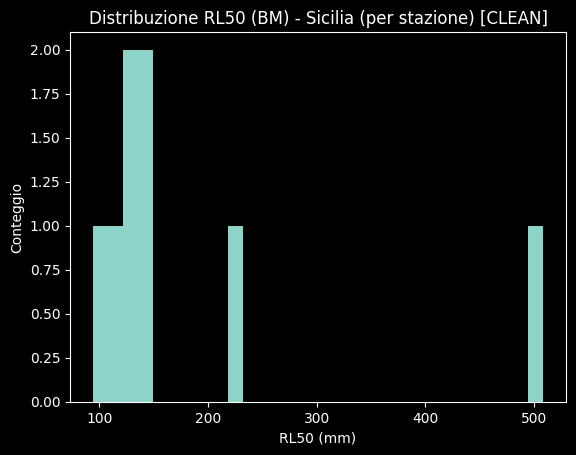

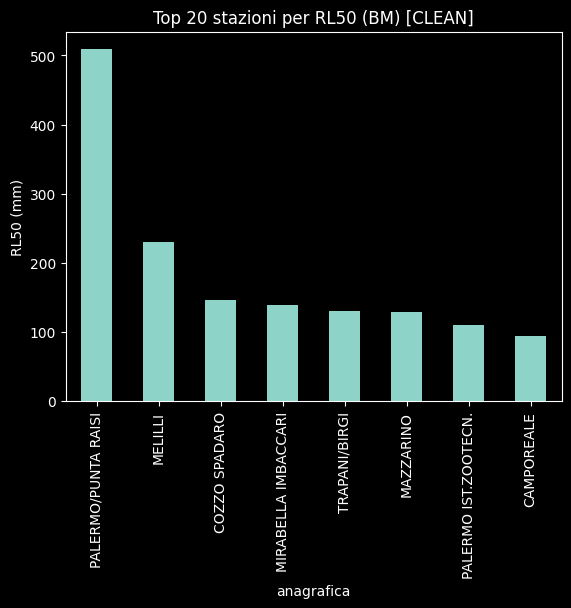

In [144]:
# ============================================================
# BLOCCO: Visualizzazione dei Return Levels (RL50) per stazione
# ============================================================
#
# SCOPO
# Visualizzare la distribuzione spaziale dei livelli di ritorno a 50 anni (RL50)
# per le stazioni siciliane che hanno superato il Quality Control.
#
# Questi grafici permettono di:
# - comprendere la variabilità degli estremi di precipitazione tra stazioni
# - identificare le aree con eventi più intensi
# - supportare interpretazioni fisiche e applicazioni di rischio
#
# ------------------------------------------------------------
# COSA FACCIAMO
#
# 1) Istogramma della distribuzione di RL50:
#    Mostra come si distribuiscono i livelli di ritorno a 50 anni
#    tra tutte le stazioni del dataset clean.
#
# 2) Bar chart delle Top 20 stazioni:
#    Ordina le stazioni per RL50 decrescente
#    e visualizza le 20 con i livelli di ritorno più elevati.
#
# ------------------------------------------------------------
# COME LEGGERE I GRAFICI
#
# Istogramma RL50:
# - Asse X: valore RL50 in millimetri
# - Asse Y: numero di stazioni che presentano quel range di RL50
# - Permette di capire se gli estremi sono concentrati
#   o se esiste forte dispersione spaziale.
#
# Top 20 stazioni:
# - Ogni barra rappresenta una stazione meteorologica
# - L’altezza indica il livello di ritorno RL50 stimato
# - Le stazioni più alte rappresentano le aree
#   con potenziale di precipitazioni estreme più intense.
#
# ------------------------------------------------------------
# PERCHÉ
#
# La rappresentazione grafica dei return levels:
# - rende immediata l’interpretazione dei risultati EVT
# - evidenzia pattern territoriali
# - fornisce un supporto diretto a pianificazione
#   e progettazione basata su livelli di ritorno.
# ============================================================

import matplotlib.pyplot as plt

plt.figure()
rl_station_clean["RL50"].plot(kind="hist", bins=30)
plt.title("Distribuzione RL50 (BM) - Sicilia (per stazione) [CLEAN]")
plt.xlabel("RL50 (mm)")
plt.ylabel("Conteggio")
plt.show()

plt.figure()
top20 = rl_station_clean.sort_values("RL50", ascending=False).head(20).set_index("anagrafica")["RL50"]
top20.plot(kind="bar")
plt.title("Top 20 stazioni per RL50 (BM) [CLEAN]")
plt.ylabel("RL50 (mm)")
plt.show()


In [145]:
# ============================================================
# BLOCCO: Analisi delle stazioni escluse dal Quality Control
# ============================================================
#
# SCOPO
# Isolare e analizzare le stazioni che sono state escluse dal dataset clean
# perché presentano stime EVT considerate statisticamente instabili.
#
# Questo passaggio serve a:
# - mantenere trasparenza sul processo di esclusione
# - documentare le cause dell’instabilità
# - evitare che le stazioni escluse vengano interpretate come assenza di dati
#
# ------------------------------------------------------------
# COSA FACCIAMO
#
# 1) Selezioniamo tutte le stazioni con flag_unstable = True.
#
# 2) Stampiamo il numero totale di stazioni escluse.
#
# 3) Ordiniamo le stazioni escluse per RL50 decrescente
#    per evidenziare i casi in cui valori elevati derivano
#    da instabilità numerica piuttosto che da estremi reali ben stimati.
#
# 4) Mostriamo, per ciascuna stazione:
#    - copertura temporale (n_years)
#    - numero di massimi annuali (n_bm)
#    - RL50 e intervalli di confidenza
#    - indicatori che spiegano il motivo dell’esclusione.
#
# ------------------------------------------------------------
# COME LEGGERE LA TABELLA
#
# flag_low_coverage = True
#   La stazione ha pochi anni di dati o pochi massimi annuali.
#
# flag_ci_explodes = True
#   L’estremo superiore dell’intervallo di confidenza RL50
#   assume valori numericamente molto elevati.
#
# flag_ci_too_wide = True
#   L’intervallo di confidenza è troppo ampio rispetto al valore stimato.
#
# Se almeno uno di questi flag è True,
# la stazione viene classificata come "instabile".
#
# ------------------------------------------------------------
# PERCHÉ È IMPORTANTE
#
# Questa tabella consente di:
# - giustificare oggettivamente l’esclusione delle stazioni
# - dimostrare che il filtraggio non è arbitrario
# - mantenere tracciabilità completa del Quality Control
# ============================================================


excluded = rl_station_qc[rl_station_qc["flag_unstable"]].copy()

print("Stazioni escluse:", len(excluded))
excluded.sort_values("RL50", ascending=False)[
    ["rete","anagrafica","n_years","n_bm","RL50","RL50_lo","RL50_hi","RL50_ci_ratio",
     "flag_low_coverage","flag_ci_explodes","flag_ci_too_wide"]
].head(30)


Stazioni escluse: 2


,rete,anagrafica,n_years,n_bm,RL50,RL50_lo,RL50_hi,RL50_ci_ratio,flag_low_coverage,flag_ci_explodes,flag_ci_too_wide
2,Sinottica,CATANIA/FONTANAROSS,63,72,223.290569,154.422171,7.643712e+05,3.422521e+03,False,True,True
3,RETE SICILIA OSS. ACQUE TEMP,S.STEFANO DI BRIGA,64,72,192.182495,141.483102,1.971441e+09,1.025817e+07,False,True,True


In [146]:
# ============================================================
# BLOCCO: Riepilogo finale del Quality Control
# ============================================================
#
# SCOPO
# Fornire un riepilogo numerico immediato dell’impatto del Quality Control
# sull’insieme delle stazioni analizzate.
#
# ------------------------------------------------------------
# COSA FACCIAMO
#
# 1) Stampiamo il numero totale di stazioni analizzate.
# 2) Stampiamo il numero di stazioni che hanno superato il Quality Control.
# 3) Calcoliamo il numero di stazioni escluse.
#
# ------------------------------------------------------------
# COME LEGGERE I RISULTATI
#
# Totale:
#   Numero complessivo di stazioni per cui è stata tentata l’analisi EVT.
#
# Clean:
#   Numero di stazioni con stime dei return levels considerate
#   statisticamente affidabili dopo il Quality Control.
#
# Escluse:
#   Numero di stazioni scartate perché presentano:
#   - copertura temporale insufficiente
#   - numero ridotto di massimi annuali
#   - intervalli di confidenza instabili o troppo ampi
#
# ------------------------------------------------------------
# PERCHÉ È IMPORTANTE
#
# Questo riepilogo:
# - quantifica l’effettiva disponibilità di dati affidabili
# - rende trasparente l’impatto del filtraggio
# - permette di valutare la robustezza complessiva dell’analisi
# ============================================================


#Perchè le abbiamo scartate?
print("Totale:", len(rl_station_qc))
print("Clean:", len(rl_station_clean))
print("Escluse:", len(rl_station_qc) - len(rl_station_clean))


Totale: 10
Clean: 8
Escluse: 2


# Trend temporale: RX1day (max giornaliero annuo)
In questa sezione calcoliamo l’indice RX1day (massimo giornaliero annuo) per ogni stazione.
Stimiamo un trend (mm/anno) e verifichiamo la significatività con un test di Mann–Kendall (two-sided).


In [147]:
# ============================================================
# BLOCCO: Calcolo dell’indice RX1day per stazione
# ============================================================
#
# SCOPO
# Calcolare per ogni stazione meteorologica il massimo giornaliero annuale
# di precipitazione, noto come indice climatico RX1day.
#
# RX1day rappresenta:
# - il valore massimo di pioggia caduta in un singolo giorno
# - per ciascun anno
# - per ciascuna stazione
#
# Questo indice è uno standard ETCCDI ampiamente utilizzato
# nello studio degli estremi pluviometrici.
#
# ------------------------------------------------------------
# COSA FACCIAMO
#
# 1) Creiamo una copia del dataset originale df_st.
# 2) Estraiamo l’anno dalla colonna data.
# 3) Raggruppiamo i dati per:
#    - stazione (anagrafica)
#    - anno
# 4) Calcoliamo il valore massimo giornaliero di precipitazione
#    per ogni coppia stazione–anno.
#
# Il risultato è una serie temporale di massimi annuali
# che verrà utilizzata per:
# - analisi dei trend temporali
# - test statistici (Mann–Kendall)
# - confronti con i modelli EVT.
#
# ------------------------------------------------------------
# PERCHÉ
#
# L’indice RX1day:
# - sintetizza l’intensità degli eventi estremi annuali
# - consente di studiare variazioni nel tempo
# - collega l’analisi EVT con l’analisi dei trend climatici
#
# ------------------------------------------------------------
# OUTPUT
#
# rx1:
# - una riga per ogni stazione e ogni anno disponibile
# - colonna RX1day con il massimo giornaliero annuale
# - base dati per il successivo test di trend
# ============================================================


#Calcolo RX1day per stazione e anno
import numpy as np
import pandas as pd

df_rx = df_st.copy()
df_rx["year"] = df_rx["data"].dt.year

rx1 = (
    df_rx.groupby(["anagrafica", "year"])["Precipitazioni cumulate"]
         .max()
         .reset_index(name="RX1day")
)

rx1.head()


,anagrafica,year,RX1day
0,CAMPOREALE,1960,52.0
1,CAMPOREALE,1961,33.6
2,CAMPOREALE,1962,75.0
3,CAMPOREALE,1963,34.4
4,CAMPOREALE,1965,43.8


In [148]:
# ============================================================
# BLOCCO: Analisi dei trend temporali dell’indice RX1day
# ============================================================
#
# SCOPO
# Valutare se i massimi giornalieri annuali di precipitazione (RX1day)
# mostrano un trend monotono nel tempo per ciascuna stazione meteorologica.
#
# Questo passaggio risponde alla domanda:
# "Gli eventi estremi giornalieri stanno aumentando nel tempo?"
#
# ------------------------------------------------------------
# PERCHÉ USIAMO IL TEST DI MANN–KENDALL
#
# Il test di Mann–Kendall è un test:
# - non parametrico
# - robusto rispetto a distribuzioni non normali
# - adatto a serie con outlier e dati mancanti
#
# Le serie RX1day:
# - contengono pochi valori per anno
# - possono avere distribuzioni asimmetriche
# - non soddisfano ipotesi di normalità
#
# Per questo Mann–Kendall è lo standard in climatologia
# per il rilevamento di trend negli indici di estremi (ETCCDI).
#
# ------------------------------------------------------------
# COSA FACCIAMO
#
# 1) Implementiamo la funzione mann_kendall_pvalue(y)
#    che calcola:
#    - S statistic (numero di coppie crescenti vs decrescenti)
#    - tau di Kendall (intensità del trend)
#    - p-value (significatività statistica)
#
# 2) Implementiamo trend_rx1_for_station(...)
#    che per ogni stazione:
#    - ordina RX1day nel tempo
#    - controlla che ci siano almeno min_years anni disponibili
#    - calcola una slope lineare (mm/anno)
#    - applica il test di Mann–Kendall
#
# ------------------------------------------------------------
# COSA MISURANO GLI OUTPUT
#
# slope:
#   Pendenza della retta di regressione lineare.
#   Indica di quanti millimetri per anno cresce o decresce RX1day.
#
# tau:
#   Coefficiente di Kendall.
#   Varia tra -1 e +1.
#   Segno positivo → tendenza crescente.
#   Segno negativo → tendenza decrescente.
#
# p_value:
#   Probabilità che il trend osservato sia dovuto al caso.
#   Se p < 0.05 → trend statisticamente significativo.
#
# n_years:
#   Numero di anni disponibili per la stazione.
#
# ------------------------------------------------------------
# COME LEGGERE I RISULTATI
#
# Se p_value < 0.05:
#   La stazione mostra un trend monotono significativo di RX1day.
#
# Se p_value ≥ 0.05:
#   Non si osserva un trend statisticamente significativo.
#
# slope e tau aiutano a quantificare l’intensità del trend,
# anche quando non è significativo.
#
# ------------------------------------------------------------
# PERCHÉ È IMPORTANTE
#
# Questo blocco collega l’analisi EVT:
# - che stima la rarità degli eventi estremi
# con l’analisi climatica:
# - che valuta se tali estremi stanno cambiando nel tempo.
#
# Insieme, forniscono una visione completa
# dell’evoluzione del rischio pluviometrico.
# ============================================================


#TREND per STAZIONE
import math

def mann_kendall_pvalue(y):
    """
    Mann-Kendall test (two-sided) con approssimazione normale.
    Ritorna: tau, p_value
    """
    y = np.asarray(y, dtype=float)
    y = y[~np.isnan(y)]
    n = len(y)
    if n < 10:
        return np.nan, np.nan

    # S statistic
    S = 0
    for i in range(n - 1):
        S += np.sum(np.sign(y[i+1:] - y[i]))

    # var(S) con correzione per ties
    unique, counts = np.unique(y, return_counts=True)
    tie_sum = np.sum(counts * (counts - 1) * (2 * counts + 5))
    varS = (n * (n - 1) * (2 * n + 5) - tie_sum) / 18.0

    if varS <= 0:
        return np.nan, np.nan

    if S > 0:
        Z = (S - 1) / math.sqrt(varS)
    elif S < 0:
        Z = (S + 1) / math.sqrt(varS)
    else:
        Z = 0.0

    # p-value two-sided dalla normal approx (erfc)
    p = math.erfc(abs(Z) / math.sqrt(2))

    # tau
    tau = S / (0.5 * n * (n - 1))
    return tau, p


def trend_rx1_for_station(station_rx1_df, min_years=30):
    """
    station_rx1_df: colonne year, RX1day per una stazione.
    Ritorna slope (mm/anno), tau, p_value, n_years.
    """
    sdf = station_rx1_df.dropna(subset=["year", "RX1day"]).sort_values("year")
    n_years = sdf["year"].nunique()
    if n_years < min_years:
        return None

    x = sdf["year"].values.astype(float)
    y = sdf["RX1day"].values.astype(float)

    # slope lineare (mm/anno)
    slope = np.polyfit(x, y, 1)[0]

    # Mann–Kendall sul valore RX1day (ordinato nel tempo)
    tau, p = mann_kendall_pvalue(y)

    return slope, tau, p, int(n_years)


In [149]:
# ============================================================
# BLOCCO: Calcolo del trend RX1day per tutte le stazioni
# ============================================================
#
# SCOPO
# Applicare l’analisi dei trend temporali dell’indice RX1day
# a tutte le stazioni meteorologiche disponibili, producendo
# una tabella riassuntiva dei risultati del test di Mann–Kendall.
#
# Questo passaggio risponde alla domanda:
# "Esistono stazioni in cui i massimi giornalieri annuali
#  mostrano un trend significativo nel tempo?"
#
# ------------------------------------------------------------
# COSA FACCIAMO
#
# 1) Raggruppiamo la tabella rx1 per stazione (anagrafica).
#
# 2) Per ciascuna stazione richiamiamo la funzione
#    trend_rx1_for_station(...), che:
#    - verifica la copertura minima di anni disponibili
#    - calcola la slope lineare (mm/anno)
#    - applica il test di Mann–Kendall
#
# 3) Scartiamo automaticamente le stazioni con serie
#    troppo corte (meno di 30 anni).
#
# 4) Salviamo per ogni stazione:
#    - slope_mm_per_year
#    - kendall_tau
#    - p_value
#    - n_years
#
# 5) Costruiamo una tabella finale ordinata
#    per slope decrescente.
#
# ------------------------------------------------------------
# COSA MISURANO I PARAMETRI FINALI
#
# slope_mm_per_year:
#   Variazione lineare media di RX1day in millimetri per anno.
#   Valore positivo → tendenza crescente.
#   Valore negativo → tendenza decrescente.
#
# kendall_tau:
#   Coefficiente di Kendall (-1 a +1).
#   Indica la direzione e la forza del trend monotono.
#
# p_value:
#   Significatività statistica del trend.
#   Se p < 0.05 → trend significativo.
#   Se p ≥ 0.05 → trend non significativo.
#
# n_years:
#   Numero di anni disponibili per il calcolo del trend.
#
# ------------------------------------------------------------
# COME LEGGERE L’OUTPUT
#
# La stampa finale mostra:
# - quante stazioni hanno una serie sufficiente per il test
# - l’elenco delle prime stazioni ordinate per slope
#
# Se nessuna stazione presenta p_value < 0.05,
# non emerge un trend monotono significativo degli estremi
# nel periodo analizzato.
#
# ------------------------------------------------------------
# PERCHÉ È IMPORTANTE
#
# Questo blocco completa l’analisi EVT:
# - i return levels descrivono la rarità degli estremi
# - il test Mann–Kendall verifica se tali estremi
#   stanno cambiando nel tempo
#
# Insieme forniscono una visione completa
# dell’evoluzione del rischio pluviometrico.
# ============================================================


#Calcolo trend per tutte le stazioni

trend_rows = []

for st, sdf in rx1.groupby("anagrafica"):
    res = trend_rx1_for_station(sdf, min_years=30)
    if res is None:
        continue
    slope, tau, p, n_years = res
    trend_rows.append({
        "anagrafica": st,
        "slope_mm_per_year": slope,
        "kendall_tau": tau,
        "p_value": p,
        "n_years": n_years
    })

trend_df = pd.DataFrame(trend_rows).sort_values("slope_mm_per_year", ascending=False).reset_index(drop=True)

print("Stazioni con RX1day trend calcolato:", len(trend_df))
trend_df.head(10)


Stazioni con RX1day trend calcolato: 10


,anagrafica,slope_mm_per_year,kendall_tau,p_value,n_years
0,PALERMO/PUNTA RAISI,0.670495,0.058681,0.519516,58
1,COZZO SPADARO,0.214130,0.147105,0.068295,72
2,S.STEFANO DI BRIGA,0.183324,0.073909,0.390718,64
3,PALERMO IST.ZOOTECN.,0.115334,0.070130,0.449468,56
4,TRAPANI/BIRGI,0.057332,0.040190,0.648679,62
5,MAZZARINO,0.057130,-0.004193,0.970242,54
6,CAMPOREALE,-0.247076,-0.077419,0.551755,31
7,MIRABELLA IMBACCARI,-0.375648,-0.131313,0.206891,45
8,CATANIA/FONTANAROSS,-0.388794,-0.141321,0.102781,63
9,MELILLI,-0.767801,-0.076649,0.533530,34


In [150]:
# ============================================================
# BLOCCO: Identificazione delle stazioni con trend RX1day significativo
# ============================================================
#
# SCOPO
# Quantificare quante stazioni meteorologiche presentano
# un trend monotono statisticamente significativo
# nei massimi giornalieri annuali di precipitazione (RX1day).
#
# Questo passaggio consente di sintetizzare l’esito
# dell’analisi dei trend a scala regionale.
#
# ------------------------------------------------------------
# COSA FACCIAMO
#
# 1) Selezioniamo le stazioni con p_value < 0.05,
#    cioè con trend significativo secondo il test di Mann–Kendall.
#
# 2) Stampiamo:
#    - numero totale di stazioni analizzate
#    - numero di stazioni con trend significativo
#    - percentuale sul totale
#
# 3) Ordiniamo le stazioni significative
#    per slope decrescente,
#    mostrando quelle con incremento più marcato.
#
# ------------------------------------------------------------
# COME LEGGERE I RISULTATI
#
# Stazioni analizzate:
#   Numero di stazioni con serie sufficienti
#   per il calcolo del trend.
#
# Trend significativo (p < 0.05):
#   Numero di stazioni che mostrano
#   un trend monotono statisticamente significativo.
#
# Percentuale:
#   Quota percentuale di stazioni con trend significativo
#   rispetto al totale analizzato.
#
# Tabella finale:
#   Elenco delle stazioni con trend significativo,
#   ordinate per incremento medio (mm/anno).
#
# ------------------------------------------------------------
# INTERPRETAZIONE CLIMATICA
#
# Se il numero di stazioni con trend significativo è basso o nullo,
# non emergono evidenze robuste di aumento sistematico
# degli estremi giornalieri nel periodo osservato.
#
# Se invece diverse stazioni mostrano trend positivi significativi,
# ciò suggerisce un possibile incremento locale
# della severità degli eventi estremi.
#
# ------------------------------------------------------------
# PERCHÉ È IMPORTANTE
#
# Questo riepilogo fornisce una risposta chiara alla domanda:
# "Gli eventi di pioggia estrema stanno diventando più intensi?"
#
# Collegando i test locali per stazione
# si ottiene una visione sintetica
# dell’evoluzione del rischio pluviometrico regionale.
# ============================================================

sig = trend_df[trend_df["p_value"] < 0.05]

print("Stazioni analizzate:", len(trend_df))
print("Trend significativo (p < 0.05):", len(sig))
print("Percentuale:", round(100 * len(sig) / max(1, len(trend_df)), 2), "%")

sig.sort_values("slope_mm_per_year", ascending=False).head(15)


Stazioni analizzate: 10
Trend significativo (p < 0.05): 0
Percentuale: 0.0 %


,anagrafica,slope_mm_per_year,kendall_tau,p_value,n_years


Nelle stazioni siciliane con serie sufficientemente lunghe, non emerge un trend crescente statisticamente significativo dei massimi giornalieri annuali nel periodo 1951–2022.

In [151]:
# ============================================================
# BLOCCO: Ranking delle stazioni per intensità del trend RX1day
# ============================================================
#
# SCOPO
# Costruire un ranking delle stazioni meteorologiche in base
# all’intensità del trend dei massimi giornalieri annuali (RX1day),
# espresso come variazione media in mm per anno.
#
# Questo passaggio consente di:
# - identificare le stazioni con trend crescenti più marcati
# - identificare le stazioni con trend decrescenti più marcati
# - esplorare la variabilità spaziale delle tendenze
#
# ------------------------------------------------------------
# COSA FACCIAMO
#
# 1) Ordiniamo la tabella trend_df per slope_mm_per_year decrescente.
#
# 2) Visualizziamo:
#    - le prime 15 stazioni con slope più elevata (trend crescente)
#    - le ultime 15 stazioni con slope più bassa (trend decrescente)
#
# 3) Usiamo display(...) per mostrare le tabelle
#    in modo leggibile nel notebook.
#
# ------------------------------------------------------------
# COME LEGGERE I RISULTATI
#
# slope_mm_per_year:
#   Variazione media annua di RX1day.
#
#   Valori positivi:
#     indicano che i massimi giornalieri annuali
#     tendono ad aumentare nel tempo.
#
#   Valori negativi:
#     indicano una tendenza alla diminuzione
#     dei massimi giornalieri annuali.
#
# kendall_tau e p_value:
#   Permettono di verificare se la tendenza osservata
#   è statisticamente significativa.
#
# ------------------------------------------------------------
# INTERPRETAZIONE
#
# Questo ranking ha valore esplorativo:
# - consente di individuare stazioni con variazioni più marcate
# - ma la significatività statistica va sempre valutata tramite p_value
#
# In particolare:
# - slope elevata + p_value < 0.05 → trend crescente significativo
# - slope elevata + p_value ≥ 0.05 → variazione non significativa
#
# ------------------------------------------------------------
# PERCHÉ È UTILE
#
# Il ranking aiuta a:
# - evidenziare aree potenzialmente soggette a variazioni locali
# - supportare approfondimenti mirati su singole stazioni
# - fornire una visione sintetica delle tendenze spaziali
# ============================================================


#RANKING
print("Top 15 slope (mm/anno):")
display(trend_df.head(15))

print("Bottom 15 slope (mm/anno):")
display(trend_df.tail(15).sort_values("slope_mm_per_year"))


Top 15 slope (mm/anno):


,anagrafica,slope_mm_per_year,kendall_tau,p_value,n_years
0,PALERMO/PUNTA RAISI,0.670495,0.058681,0.519516,58
1,COZZO SPADARO,0.214130,0.147105,0.068295,72
2,S.STEFANO DI BRIGA,0.183324,0.073909,0.390718,64
3,PALERMO IST.ZOOTECN.,0.115334,0.070130,0.449468,56
4,TRAPANI/BIRGI,0.057332,0.040190,0.648679,62
5,MAZZARINO,0.057130,-0.004193,0.970242,54
6,CAMPOREALE,-0.247076,-0.077419,0.551755,31
7,MIRABELLA IMBACCARI,-0.375648,-0.131313,0.206891,45
8,CATANIA/FONTANAROSS,-0.388794,-0.141321,0.102781,63
9,MELILLI,-0.767801,-0.076649,0.533530,34


Bottom 15 slope (mm/anno):


,anagrafica,slope_mm_per_year,kendall_tau,p_value,n_years
9,MELILLI,-0.767801,-0.076649,0.533530,34
8,CATANIA/FONTANAROSS,-0.388794,-0.141321,0.102781,63
7,MIRABELLA IMBACCARI,-0.375648,-0.131313,0.206891,45
6,CAMPOREALE,-0.247076,-0.077419,0.551755,31
5,MAZZARINO,0.057130,-0.004193,0.970242,54
4,TRAPANI/BIRGI,0.057332,0.040190,0.648679,62
3,PALERMO IST.ZOOTECN.,0.115334,0.070130,0.449468,56
2,S.STEFANO DI BRIGA,0.183324,0.073909,0.390718,64
1,COZZO SPADARO,0.214130,0.147105,0.068295,72
0,PALERMO/PUNTA RAISI,0.670495,0.058681,0.519516,58


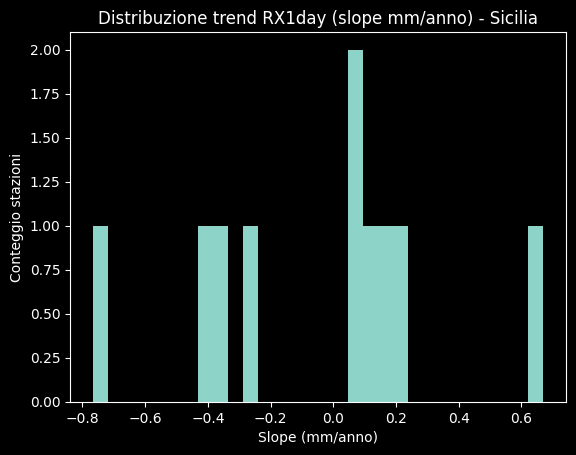

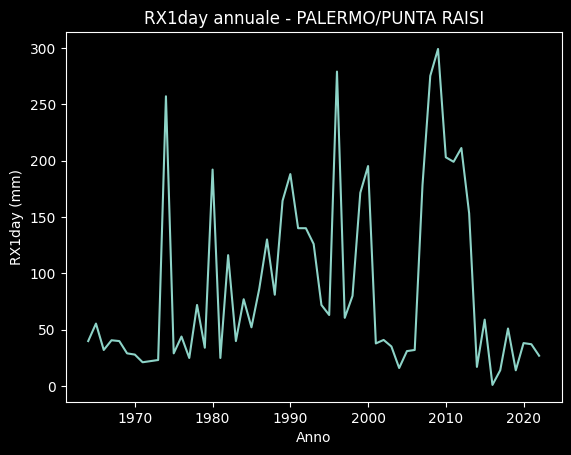

,anagrafica,slope_mm_per_year,kendall_tau,p_value,n_years
0,PALERMO/PUNTA RAISI,0.670495,0.058681,0.519516,58


In [152]:
# ============================================================
# BLOCCO: Visualizzazione della distribuzione dei trend RX1day
#          e esempio di serie temporale per una stazione
# ============================================================
#
# SCOPO
# Fornire una rappresentazione grafica finale dei risultati
# dell’analisi dei trend dei massimi giornalieri annuali (RX1day).
#
# Questo blocco permette di:
# - osservare la distribuzione complessiva delle slope tra stazioni
# - visualizzare un esempio concreto di evoluzione temporale
#   della precipitazione estrema in una singola stazione
#
# ------------------------------------------------------------
# COSA FACCIAMO
#
# 1) Istogramma delle slope_mm_per_year:
#    Mostra come si distribuiscono le variazioni annue di RX1day
#    tra tutte le stazioni analizzate.
#
# 2) Selezioniamo la stazione con slope più elevata
#    (prima nel ranking dei trend).
#
# 3) Plottiamo la serie temporale RX1day di questa stazione:
#    - asse X: anni
#    - asse Y: massimo giornaliero annuale di precipitazione
#
# 4) Visualizziamo infine i parametri di trend
#    (slope, tau, p_value) associati alla stazione scelta.
#
# ------------------------------------------------------------
# COME LEGGERE I GRAFICI
#
# Istogramma slope:
# - Asse X: slope in mm/anno
# - Asse Y: numero di stazioni
# - Valori centrati intorno a zero indicano assenza di trend diffuso
# - Code positive o negative indicano possibili tendenze locali
#
# Serie temporale RX1day della stazione esempio:
# - Ogni punto rappresenta il massimo giornaliero annuale
# - Una pendenza crescente visiva suggerisce aumento degli estremi
# - La significatività statistica è confermata dal p_value
#
# ------------------------------------------------------------
# INTERPRETAZIONE
#
# Questo doppio grafico:
# - collega il risultato statistico al comportamento reale dei dati
# - permette di verificare visivamente il significato della slope
# - rende l’analisi facilmente comunicabile anche a non specialisti
#
# ------------------------------------------------------------
# PERCHÉ È IMPORTANTE
#
# Chiudere l’analisi con una visualizzazione concreta:
# - rende i risultati più comprensibili
# - rafforza la credibilità dell’approccio quantitativo
# - completa il percorso: dati → modelli → trend → interpretazione
# ============================================================


#Plot: distribuzione slope + esempio stazione
import matplotlib.pyplot as plt

plt.figure()
trend_df["slope_mm_per_year"].plot(kind="hist", bins=30)
plt.title("Distribuzione trend RX1day (slope mm/anno) - Sicilia")
plt.xlabel("Slope (mm/anno)")
plt.ylabel("Conteggio stazioni")
plt.show()

# esempio: stazione con slope più alto
example = trend_df.iloc[0]["anagrafica"]
tmp = rx1[rx1["anagrafica"] == example].sort_values("year")

plt.figure()
plt.plot(tmp["year"], tmp["RX1day"])
plt.title(f"RX1day annuale - {example}")
plt.xlabel("Anno")
plt.ylabel("RX1day (mm)")
plt.show()

trend_df[trend_df["anagrafica"] == example]


In [153]:
trend_df.to_csv("sicilia_trend_RX1day_per_stazione.csv", index=False)
print("Salvato: sicilia_trend_RX1day_per_stazione.csv")


Salvato: sicilia_trend_RX1day_per_stazione.csv


Interpretazione:
- Lo slope (mm/anno) misura la variazione media del massimo giornaliero annuo (RX1day) nel tempo.
- Il test di Mann–Kendall verifica la presenza di un trend monotono; p < 0.05 indica evidenza statistica di trend.
- I risultati vanno interpretati insieme alla copertura temporale (n_years) e alla completezza della serie.
